In [1]:
import torch
import numpy as np
import math

from tqdm import tqdm
from diffusion.respace import space_timesteps
from sklearn.decomposition import PCA  # Changed from TSNE
import scipy.stats as stats
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
num_train_diffusion_timestep = 1000
num_sample_diffusion_timestep = 100
num_ar_timestep = 100
num_tokens = 256

denoise_t_per_step = num_sample_diffusion_timestep // num_ar_timestep
time_mapper = list(space_timesteps(num_train_diffusion_timestep, str(num_sample_diffusion_timestep)))
time_mapper.sort()
time_mapper = torch.tensor(time_mapper).cuda()

training_sample =500000
sample_sample = 50

In [3]:
training_dist = []
mask_ratio_generator = stats.truncnorm((0.7 - 1.0) / 0.25, 0, loc=1.0, scale=0.25)

def sample_orders():
    order = np.array(list(range(num_tokens)))
    np.random.shuffle(order)
    order = torch.tensor(order)
    return order

def random_masking(orders):
    # generate token mask
    mask_rate = mask_ratio_generator.rvs(1)[0]
    num_masked_tokens = int(np.ceil(num_tokens * mask_rate))
    mask = torch.zeros(num_tokens)
    mask = torch.scatter(mask, dim=-1, index=orders[:num_masked_tokens],
                            src=torch.ones(num_tokens))
    return mask

# for _ in tqdm(range(training_sample)):
#     sample = torch.randint(0, num_train_diffusion_timestep, size=(num_tokens,))
#     training_dist.append(sample)

for _ in tqdm(range(training_sample)):
    sample = torch.randint(0, num_train_diffusion_timestep, size=(num_tokens,))
    order = sample_orders()
    mask = random_masking(order).bool()
    training_dist.append(sample)
    sample1 = sample.clone()
    sample1[mask] = num_train_diffusion_timestep - 1
    sample2 = sample.clone()
    sample2[mask] = 0
    training_dist.append(sample1)
    training_dist.append(sample2)


100%|██████████| 500000/500000 [02:47<00:00, 2987.90it/s]


In [4]:
sample_dist = []

def mask_by_order(mask_len, order, seq_len):
    masking = torch.zeros(seq_len).cuda()
    masking = torch.scatter(masking, dim=-1, index=order[:mask_len.long()], src=torch.ones(seq_len).cuda()).bool()
    return masking
def sample_orders():
    order = np.array(list(range(num_tokens)))
    np.random.shuffle(order)
    order = torch.tensor(order)
    return order

for _ in tqdm(range(sample_sample)):
    mask = torch.ones(num_tokens).cuda()
    orders = sample_orders().cuda()
    t_map = torch.ones((num_tokens), dtype=torch.long).cuda() * (num_sample_diffusion_timestep - 1)
    done_map = torch.zeros((num_tokens), dtype=torch.bool).cuda()
    denoising_map = torch.zeros((num_tokens), dtype=torch.bool).cuda()

    sample_dist.append(time_mapper[t_map])

    cnt = 0

    indices = list(range(num_ar_timestep))
    while torch.all(done_map) == False:
        step = indices[cnt] if cnt < len(indices) else indices[-1]
        mask_ratio = np.cos(math.pi / 2. * (step + 1) / num_sample_diffusion_timestep)
        mask_len = torch.Tensor([np.floor(num_tokens * mask_ratio)]).cuda()
        # # masks out at least one for the next iteration
        mask_len = torch.maximum(torch.Tensor([1]).cuda(),
                                    torch.minimum(torch.sum(mask, dim=-1, keepdims=True) - 1, mask_len))
        
        # get masking for next iteration and locations to be predicted in this iteration
        mask_next = mask_by_order(mask_len[0], orders, num_tokens)
        if step >= num_sample_diffusion_timestep - 1:
            mask_to_pred = mask.bool()
        else:
            mask_to_pred = torch.logical_xor(mask.bool(), mask_next.bool())
        mask = mask_next

        denoising_map[mask_to_pred] = True
        denoising_map[done_map] = False


        t_map[denoising_map.nonzero(as_tuple=True)] = t_map[denoising_map.nonzero(as_tuple=True)] - denoise_t_per_step
        assert (t_map >= -1).all()
        t_map[t_map == -1] = 0
        done_map[t_map == 0] = True

        sample_dist.append(time_mapper[t_map])

        cnt += 1

100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


In [5]:
training_dist = torch.stack(training_dist, dim=0) / 1000
sample_dist = torch.stack(sample_dist, dim=0) / 1000

Combined data shape: (1509950, 256)
Running t-SNE... This might take a moment.
Running PCA...
t-SNE transformation complete.
t-SNE results shape: (1509950, 2)
Generating plot...


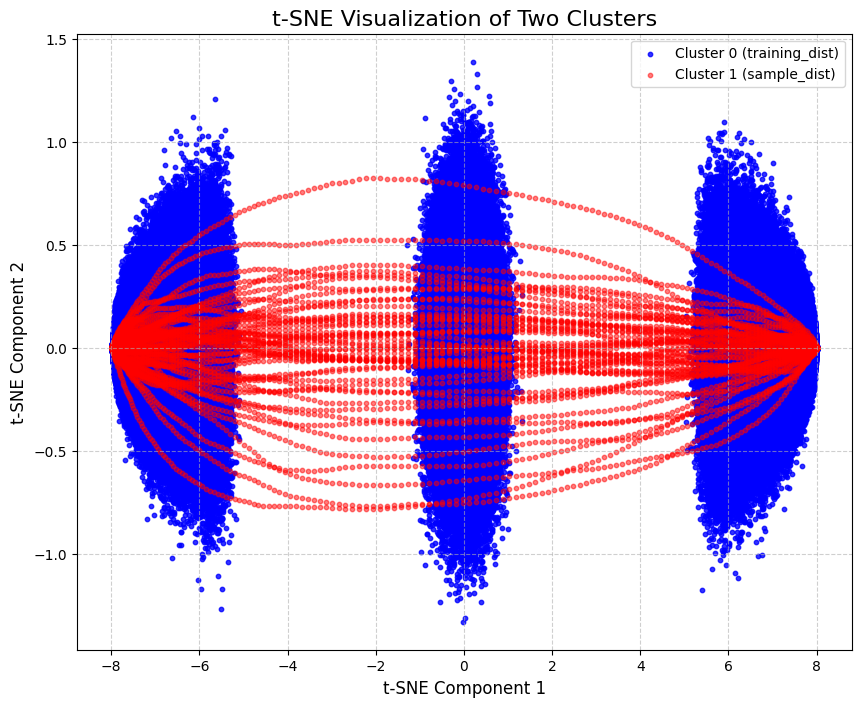

In [6]:
# --- Prepare Data for t-SNE ---

# 1. Convert PyTorch tensors to NumPy arrays
# .detach() - Detaches from the computation graph
# .cpu() - Moves the tensor to the CPU (if it was on GPU)
# .numpy() - Converts to a NumPy array
data_cluster_0 = training_dist.detach().cpu().numpy()
data_cluster_1 = sample_dist.detach().cpu().numpy()

# 2. Combine the datasets into one
combined_data = np.vstack((data_cluster_0, data_cluster_1))
print(f"Combined data shape: {combined_data.shape}")

# 3. Create labels for each dataset
# Label 0 for 'training_dist' (10 samples)
labels_cluster_0 = np.zeros(data_cluster_0.shape[0])
labels_cluster_1 = np.ones(data_cluster_1.shape[0])
combined_labels = np.concatenate((labels_cluster_0, labels_cluster_1))

# --- Run t-SNE ---

print("Running t-SNE... This might take a moment.")
# Initialize t-SNE
# n_components=2 for a 2D plot
# perplexity is a key parameter; default is 30.
#   Since one cluster is very small (10), a lower perplexity might be needed.
#   Let's adjust it based on the smallest class size.
# perplexity_value = min(30.0, float(data_cluster_0.shape[0] - 1))
# if perplexity_value < 5:
#     print(f"Warning: Very small cluster size ({data_cluster_0.shape[0]}). Setting perplexity to {perplexity_value}.")
#     if perplexity_value <= 0:
#         perplexity_value = 5 # Need at least some perplexity
#         print("Adjusting perplexity to 5.")


# tsne = TSNE(n_components=2,
#             perplexity=perplexity_value,
#             random_state=42,
#             n_iter=250,
#             init='pca',
#             learning_rate='auto',
#             verbose=True)


# Fit and transform the data
# tsne_results = tsne.fit_transform(combined_data)


print("Running PCA...")
# Initialize PCA
# n_components=2 for a 2D plot
pca = PCA(n_components=2, random_state=42)
tsne_results = pca.fit_transform(combined_data)


print("t-SNE transformation complete.")
print(f"t-SNE results shape: {tsne_results.shape}")

# --- Plot the Results ---

print("Generating plot...")
plt.figure(figsize=(10, 8))

# Scatter plot for Cluster 0 ('training_dist')
cluster_0_points = tsne_results[combined_labels == 0]
plt.scatter(
    cluster_0_points[:, 0],
    cluster_0_points[:, 1],
    label='Cluster 0 (training_dist)',
    alpha=0.8,
    c='blue',
    s=10 # Make them slightly larger to be visible
)

# Scatter plot for Cluster 1 ('sample_dist')
cluster_1_points = tsne_results[combined_labels == 1]
plt.scatter(
    cluster_1_points[:, 0],
    cluster_1_points[:, 1],
    label='Cluster 1 (sample_dist)',
    alpha=0.5,
    c='red',
    s=10
)

plt.title('t-SNE Visualization of Two Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Optionally, display the plot if in an interactive environment
plt.show()
